In [1]:
import pandas as pd
import numpy as np
import re
df_tweets = pd.read_csv("./data/tweets_labelled_same_opinion.csv")

In [2]:
df_tweets

,id,label,tweet
0,5dcaf694c14b24d0701c04f2,1,- @GretaThunberg is fighting for the planet a...
1,5dcaf697c14b24d0701c052e,0,"""A Fox News guest called Greta Thunberg â€˜men..."
2,5dcaf681c14b24d0701c0392,1,"""How dare you?"" Il discorso di Greta Thunberg ..."
3,5dcaf699c14b24d0701c0553,0,"""How dare you?""\n\nI stan for Greta Thunberg w..."
4,5dcaf698c14b24d0701c0549,1,&amp;#8220;She seems like a very happy young g...
...,...,...,...
1052,5dc8857a678e6d23f7706562,1,When they figure out this is impacting their t...
1053,5dcabb4edd8a420f9f1d57e5,0,Who is more unlikeable: David Hogg or Greta Th...
1054,5dcca703f372816fadd094d5,0,Why don't you sail to south Pole to see if th...
1055,5dcabb49dd8a420f9f1d576e,0,Wow talk about you Democratsare doing just wha...


In [3]:
print(df_tweets["label"].value_counts()) # Here should be balanced almost 50% pos 50% neg

0    760
1    297
Name: label, dtype: int64


In [4]:
# BAG OF WORDS - Should be created every time we introduce new data o our pipeline.
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer(lowercase = False, max_features = 50)
bag_of_words = vectorize.fit_transform(df_tweets["tweet"])


In [5]:
print(bag_of_words.shape)

(1057, 50)


In [6]:
# Create a Logistic Regression Model
from sklearn.model_selection import train_test_split

train, test, class_train, class_test = train_test_split(bag_of_words,
                                                              df_tweets["label"],
                                                              random_state = 42)


In [7]:
# See how our data is divided between train and test.
print(train.shape) # 75% 
print(test.shape)  # 25%

(792, 50)
(265, 50)


### Functions to build Data Visualization and help us analize the data and decide next treatment on the pipeline

In [8]:
# Pareto bar chart 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def wordCloud_chart(df, text_column, label_value):
    qry_result = df.query("label == " + label_value)
    all_words = ' '.join([text for text in qry_result[text_column]])
    word_cloud = WordCloud(width = 800, height = 500,
                                max_font_size=110, collocations=False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [9]:
def pareto(df, text_column, num_rows):
    all_words = ' '.join([text for text in df[text_column]])
    frequency = nltk.FreqDist(token_space.tokenize(all_words))
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = num_rows)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x= "Word", y = "Frequency")
    ax.set(ylabel = "Count")
    plt.show() 

In [10]:
from sklearn.linear_model import LogisticRegression
def text_classification(df, text_column, label):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(df[text_column])
    train, test, class_train, class_test = train_test_split(bag_of_words,
                                                                 df[label],
                                                                 random_state = 42)
    
    logistic_regression = LogisticRegression(solver="lbfgs")
    logistic_regression.fit(train, class_train)
    
    # return the accuracy
    return logistic_regression.score(test, class_test)

In [11]:
# Function to remove some patterns
def clear_text(text, pattern):
    
    # Find the pattern
    r = re.findall(pattern, text)
    
    # Removes the pattern from the sentence
    for i in r:
        text = re.sub(i,"",text)
    
    return text

# Pipeline

### First analysis before start data treatment 

In [12]:
first_accuracy = text_classification(df_tweets, 'tweet' ,'label')
first_accuracy

0.8

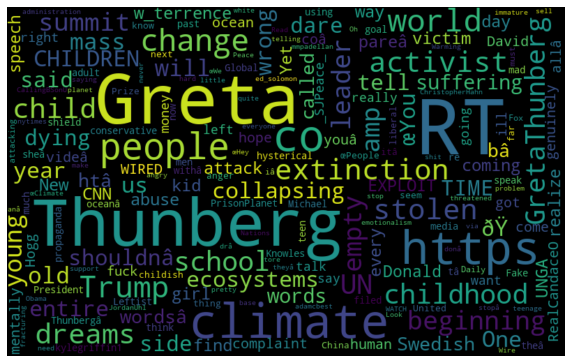

In [13]:
# wordCloud of negative tweets
wordCloud_chart(df_tweets, 'tweet' ,'0')

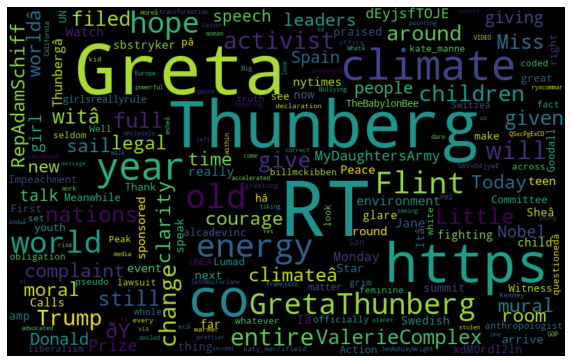

In [14]:
# wordCloud of positive tweets
wordCloud_chart(df_tweets, 'tweet' ,'1')

### Tokenization

In [15]:
from nltk import tokenize
import nltk

token_space = tokenize.WhitespaceTokenizer()
all_words = ' '.join([text for text in df_tweets["tweet"]])
frequency = nltk.FreqDist(token_space.tokenize(all_words))
df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                             "Frequency": list(frequency.values())})


In [16]:
df_frequency.head()

,Word,Frequency
0,-,25
1,@GretaThunberg,19
2,is,451
3,fighting,14
4,for,188


In [17]:
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 10)
df_frequency

,Word,Frequency
874,RT,934
20,Greta,718
5,the,717
21,Thunberg,515
2,is,451
54,a,401
82,to,370
10,of,364
280,are,321
7,and,315


### First treatment: remove words, characters, and patterns typical of tweets 

In [18]:
# NumPy Vectorization is much more faster than for loops when we work with large datasets
# Remove "@user" pattern 

df_tweets['treatment_1'] = np.vectorize(clear_text)(df_tweets['tweet'], "@[\w]*")
df_tweets['treatment_1'] = np.vectorize(clear_text)(df_tweets['treatment_1'], "RT :*")

# Remove punctuation, numbers, and special characters
df_tweets['treatment_1'] = df_tweets['treatment_1'].str.replace("[^a-zA-Z#]", " ")


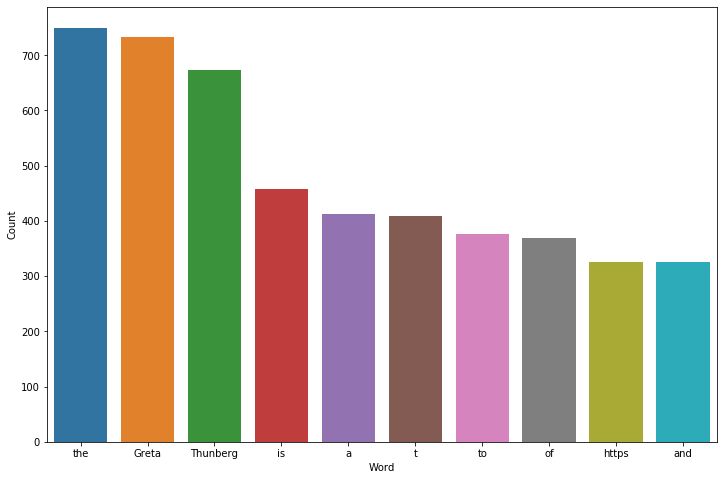

In [19]:
# Get the top 10 words
pareto(df_tweets, 'treatment_1', 10)

In [20]:
second_accuracy = text_classification(df_tweets, 'treatment_1' ,'label')
print("Accuracy evolution {}, {}".format(first_accuracy,second_accuracy))

Accuracy evolution 0.8, 0.8377358490566038


### Second treatment: Removing stop words

In [21]:
stopwords = nltk.corpus.stopwords.words("english")
new_tweets = list()

for tweet in df_tweets["treatment_1"]:
    new_phrase = list()
    text_words = token_space.tokenize(tweet)
    for word in text_words:
        if word not in stopwords:
            new_phrase.append(word)
    new_tweets.append(' '.join(new_phrase))
    
df_tweets["treatment_2"] = new_tweets

In [22]:
df_tweets.head()

,id,label,tweet,treatment_1,treatment_2
0,5dcaf694c14b24d0701c04f2,1,- @GretaThunberg is fighting for the planet a...,is fighting for the planet and the living ...,fighting planet living conditions grandchildre...
1,5dcaf697c14b24d0701c052e,0,"""A Fox News guest called Greta Thunberg â€˜men...",A Fox News guest called Greta Thunberg men...,A Fox News guest called Greta Thunberg mentall...
2,5dcaf681c14b24d0701c0392,1,"""How dare you?"" Il discorso di Greta Thunberg ...",How dare you Il discorso di Greta Thunberg ...,How dare Il discorso di Greta Thunberg Onu htt...
3,5dcaf699c14b24d0701c0553,0,"""How dare you?""\n\nI stan for Greta Thunberg w...",How dare you I stan for Greta Thunberg who...,How dare I stan Greta Thunberg berated world l...
4,5dcaf698c14b24d0701c0549,1,&amp;#8220;She seems like a very happy young g...,amp # She seems like a very happy young g...,amp # She seems like happy young girl amp # Pr...


In [2]:
third_accuracy = text_classification(df_tweets, "treatment_2", "label")
print("Accuracy evolution {}, {}, {}".format(first_accuracy,second_accuracy, third_accuracy))

NameError: name 'text_classification' is not defined

### Negative wordCloud

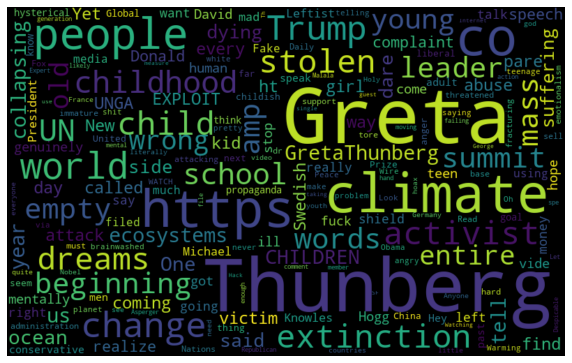

In [24]:
wordCloud_chart(df_tweets, "treatment_2", '0')

### Postive wordCloud

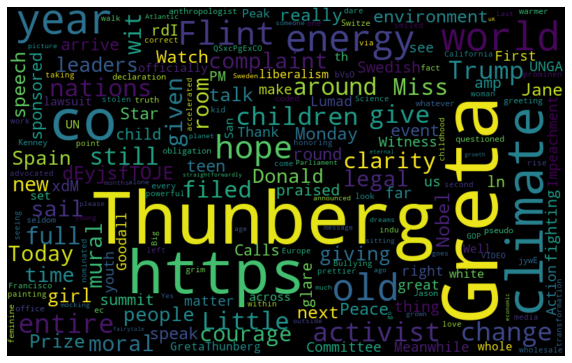

In [25]:
wordCloud_chart(df_tweets, "treatment_2", '1')

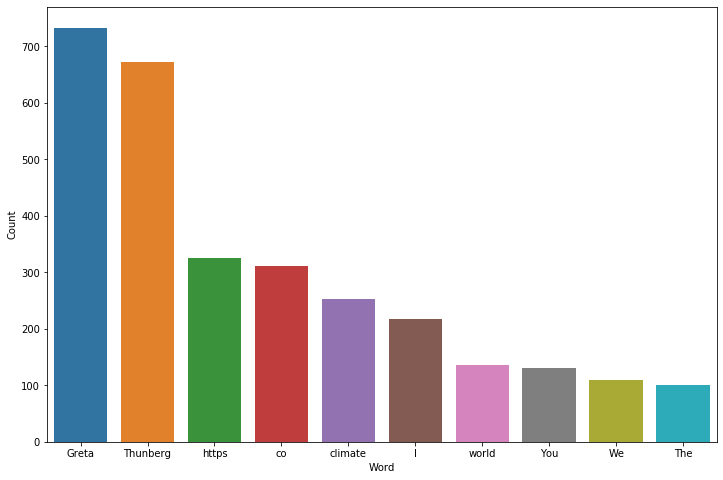

In [26]:

pareto(df_tweets, "treatment_2", 10)

### Third treatment: Stemming

In [27]:
from nltk import PorterStemmer # Basically transform variation of words like gerund in the root word.   
ps = PorterStemmer()

tokenized_tweet = df_tweets['treatment_2'].apply(lambda x: x.split())
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

tokenized_tweet.head()

0    [fight, planet, live, condit, grandchildren, y...
1    [A, fox, new, guest, call, greta, thunberg, me...
2    [how, dare, Il, discorso, di, greta, thunberg,...
3    [how, dare, I, stan, greta, thunberg, berat, w...
4    [amp, #, she, seem, like, happi, young, girl, ...
Name: treatment_2, dtype: object

In [28]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df_tweets['treatment_3'] = tokenized_tweet
    
fourth_accuracy = text_classification(df_tweets, "treatment_3", "label")

In [29]:
print("Accuracy evolution {}, {}, {}, {}".format(first_accuracy,second_accuracy, third_accuracy, fourth_accuracy))

Accuracy evolution 0.8, 0.8377358490566038, 0.7962264150943397, 0.8188679245283019


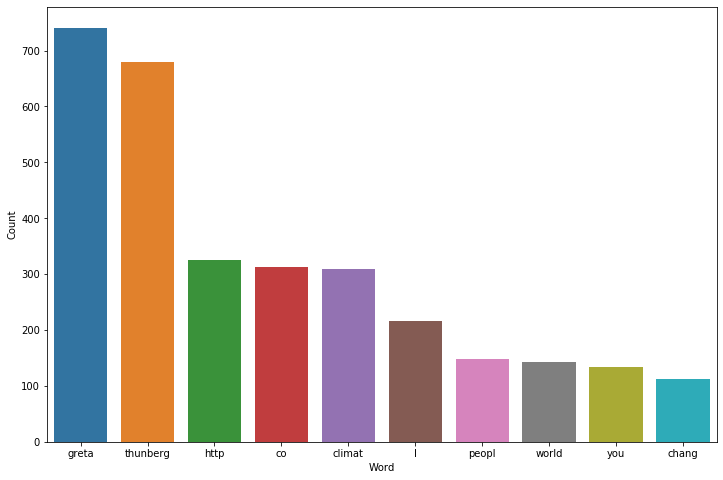

In [30]:
pareto(df_tweets, "treatment_3", 10)

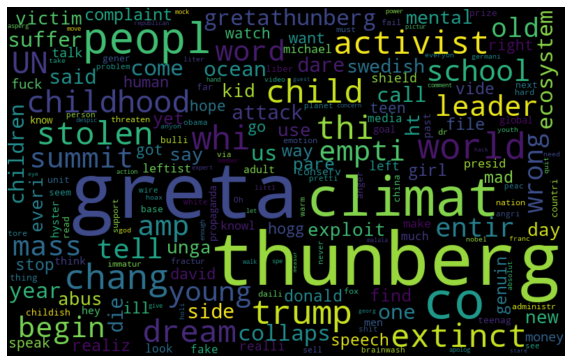

In [31]:
wordCloud_chart(df_tweets, "treatment_3","0")

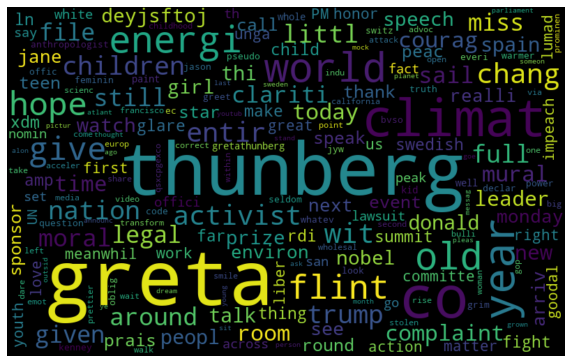

In [32]:
wordCloud_chart(df_tweets, "treatment_3","1")

### Fourth Treatment: TF-IDF

In [33]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
logistic_regression = LogisticRegression(solver="lbfgs")
tfidf = TfidfVectorizer(lowercase=False, max_features=1000) # 50

treated_tfidf = tfidf.fit_transform(df_tweets["treatment_3"])
train, test, class_train, class_test = train_test_split(treated_tfidf,
                                                        df_tweets["label"],
                                                        random_state = 42)
logistic_regression.fit(train, class_train)
fifth_accuracy = logistic_regression.score(test, class_test) # 0.8113207547169812  0.8603773584905661

print("Accuracy evolution {}, {}, {}, {}, {}".format(first_accuracy,second_accuracy, third_accuracy, fourth_accuracy,fifth_accuracy))

Accuracy evolution 0.8, 0.8377358490566038, 0.7962264150943397, 0.8188679245283019, 0.8603773584905661


In [38]:
class_test 

260     1
832     0
846     1
1007    0
88      0
       ..
865     0
261     0
298     0
494     0
869     0
Name: label, Length: 265, dtype: int64

### Fifth Treatment: NGrams

In [39]:
from nltk import ngrams
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
vetor_tfidf = tfidf.fit_transform(df_tweets["treatment_3"])
train, test, class_train, class_test = train_test_split(vetor_tfidf,
                                                        df_tweets["label"],
                                                        random_state = 42)
logistic_regression.fit(train, class_train)
accuracy_tfidf_ngrams = logistic_regression.score(test, class_test)
print(accuracy_tfidf_ngrams)

0.8452830188679246


In [40]:
tfidf = TfidfVectorizer(lowercase=False)
vetor_tfidf = tfidf.fit_transform(df_tweets["treatment_2"])
train, test, class_train, class_test = train_test_split(vetor_tfidf,
                                                        df_tweets["label"],
                                                        random_state = 42)
logistic_regression.fit(train, class_train)
accuracy_tfidf = logistic_regression.score(test, class_test)
print(accuracy_tfidf)

0.8490566037735849
